In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Web Scraping

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

LETTERS = [
    "a","b","c","d","e","f","g","h","i","j","k","l",
    "m","n","ng","o","p","r","s","t","u","v","w","y"
]

BASE_URL = "https://www.webonary.org/bolinao/browse-vernacular-english/?letter={}&key=smk&pagenr={}"

def scrape_bolinao_all(delay=1):
    records = []

    for letter in LETTERS:
        print(f"\n=== Scraping letter '{letter}' ===")
        page = 1
        while True:
            url = BASE_URL.format(letter, page)
            print(f"  Page {page} -> {url}")
            resp = requests.get(url)
            resp.raise_for_status()
            soup = BeautifulSoup(resp.text, "html.parser")

            # Check if page has "no entries"
            if soup.select_one("div#searchresults"):
                msg = soup.select_one("div#searchresults").get_text(strip=True)
                if "No entries exist" in msg:
                    print(f"    Stopping: {msg}")
                    break

            # Loop entries
            for entry in soup.select("div.entry"):
                # Word
                word_tag = entry.select_one("span.mainheadword, span.lexeme, span.vernacular")
                word = word_tag.get_text(" ", strip=True) if word_tag else ""

                # Part of speech
                pos_tag = entry.select_one("span.partofspeech")
                pos = pos_tag.get_text(strip=True) if pos_tag else ""

                # English meaning
                eng_def = " ".join(
                    d.get_text(" ", strip=True)
                    for d in entry.select("span.definitionorgloss span[lang='en']")
                )

                # Filipino meaning
                fil_def = " ".join(
                    d.get_text(" ", strip=True)
                    for d in entry.select("span.definitionorgloss span[lang='tl']")
                )

                # Bolinao explanation
                bol_def = " ".join(
                    d.get_text(" ", strip=True)
                    for d in entry.select("span.definitionorgloss span[lang='smk']")
                )

                # Example sentence(s)
                example = " ".join(
                    e.get_text(" ", strip=True)
                    for e in entry.select("span.examplescontent span.example")
                )

                # Example translation(s)
                example_trans = " ".join(
                    t.get_text(" ", strip=True)
                    for t in entry.select("span.translationcontent span.translation")
                )

                if word:
                    records.append({
                        "letter": letter,
                        "page": page,
                        "word": word,
                        "part_of_speech": pos,
                        "meaning_english": eng_def,
                        "meaning_filipino": fil_def,
                        "meaning_bolinao": bol_def,
                        "sample_bolinao": example,
                        "sample_english": example_trans
                    })

            page += 1
            time.sleep(delay)

    return pd.DataFrame(records)


# Run scraper
df = scrape_bolinao_all(delay=1)

# Save to CSV
df.to_csv("bolinao_lexicon.csv", index=False, encoding="utf-8")
print("\nScraping finished! Saved to bolinao_lexicon.csv")



=== Scraping letter 'a' ===
  Page 1 -> https://www.webonary.org/bolinao/browse-vernacular-english/?letter=a&key=smk&pagenr=1
  Page 2 -> https://www.webonary.org/bolinao/browse-vernacular-english/?letter=a&key=smk&pagenr=2
  Page 3 -> https://www.webonary.org/bolinao/browse-vernacular-english/?letter=a&key=smk&pagenr=3


KeyboardInterrupt: 

# Data Preprocessing

## Data Cleaning using the 'word' column

In [ ]:
import pandas as pd
import numpy as np

def clean_lexicon(filepath='/content/drive/MyDrive/Colab Notebooks/datasets/bolinao_lexicon_all.csv'):
    """
    Loads and cleans the Bolinao lexicon with refined rules for handling symbols.
    """
    # --- 1. Load the Dataset ---
    try:
        df = pd.read_csv(filepath)
        cleaned_df = df.copy()

        word_column = cleaned_df.columns[0]

        initial_word_count = len(cleaned_df)
        print(f"Successfully loaded '{filepath}'.")
        print(f"Initial word count: {initial_word_count}")

        # --- 2. Perform Initial Cleaning ---
        cleaned_df.dropna(subset=[word_column], inplace=True)
        cleaned_df[word_column] = cleaned_df[word_column].astype(str)
        cleaned_df[word_column] = cleaned_df[word_column].str.lower()
        cleaned_df[word_column] = cleaned_df[word_column].str.strip()

        # --- 3. Refined Symbol Filtering ---
        # Rule 1: Identify words with invalid characters (anything not a-z, ', or -)
        invalid_char_mask = cleaned_df[word_column].str.contains(r"[^a-z'-]", na=False)

        # Rule 2: Identify words with leading hyphens
        leading_hyphen_mask = cleaned_df[word_column].str.startswith('-', na=False)

        # Rule 3: Identify words with trailing hyphens
        trailing_hyphen_mask = cleaned_df[word_column].str.endswith('-', na=False)

        # Combine masks to find all words that should be removed
        words_to_remove_mask = invalid_char_mask | leading_hyphen_mask | trailing_hyphen_mask

        # Keep only the words that are NOT in the removal mask
        cleaned_df = cleaned_df[~words_to_remove_mask]

        # --- 4. Finalize and Save ---
        # Remove any entries that might have become empty
        cleaned_df[word_column] = cleaned_df[word_column].replace('', np.nan)
        cleaned_df.dropna(subset=[word_column], inplace=True)

        # Remove duplicate words
        cleaned_df.drop_duplicates(subset=[word_column], inplace=True)

        final_word_count = len(cleaned_df)
        words_removed = initial_word_count - final_word_count

        output_filename = 'bolinao_lexicon_cleaned_refined.csv'
        cleaned_df.to_csv(output_filename, index=False)

        print("\n--- Cleaning Complete ---")
        print(f"Removed words with invalid symbols or leading/trailing hyphens.")
        print(f"Total words removed: {words_removed}")
        print(f"The cleaned dataset with {final_word_count} unique words has been saved to '{output_filename}'.")

        return cleaned_df

    except FileNotFoundError:
        print(f"Error: '{filepath}' not found. Please ensure it's in the same directory.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- To run the script ---
if __name__ == '__main__':
    cleaned_data = clean_lexicon()
    if cleaned_data is not None:
        print("\nHere is a preview of the refined data:")
        print(cleaned_data.head())

Successfully loaded '/content/drive/MyDrive/Colab Notebooks/datasets/bolinao_lexicon_all.csv'.
Initial word count: 21083

--- Cleaning Complete ---
Removed words with invalid symbols or leading/trailing hyphens.
Total words removed: 746
The cleaned dataset with 20337 unique words has been saved to 'bolinao_lexicon_cleaned_refined.csv'.

Here is a preview of the refined data:
     word part_of_speech                                    meaning_english  \
2    a'lo              n  Pestle, a rounded piece of wood about five inc...   
3   a'nak              n  Referring to specific children individually, n...   
4   a'nem              n                    Six, the number following five.   
5   a'pat              n                                              Four.   
6  a'rong              n                                              Nose.   

  meaning_filipino                                     sample_bolinao  \
2            Halo.      Kustoy byat nansi a'lonman'ipambayo kon irik.   
3

## Data Cleaning using the 'part-of-speech' column

In [ ]:
import pandas as pd

def filter_derivational_pos(filepath='/content/bolinao_lexicon_cleaned_v2.csv'):
    """
    Loads the lexicon and removes rows that indicate a derivational
    part of speech (containing '>' in the 'part_of_speech' column).
    """
    # --- 1. Load the Dataset ---
    try:
        df = pd.read_csv(filepath)
        initial_count = len(df)
        print(f"Successfully loaded '{filepath}'.")
        print(f"Initial row count: {initial_count}")

        # --- 2. Filter the Rows ---
        # Check if the required column exists
        if 'part_of_speech' in df.columns:
            # Ensure the column is treated as a string to handle potential numbers or NaNs
            df['part_of_speech'] = df['part_of_speech'].astype(str)

            # Create a boolean mask to identify rows to KEEP.
            # We keep rows where the 'part_of_speech' column does NOT contain '>'.
            # The ~ symbol negates the condition.
            rows_to_keep_mask = ~df['part_of_speech'].str.contains('>', na=False)

            # Apply the mask to create the new, filtered DataFrame
            filtered_df = df[rows_to_keep_mask]

            final_count = len(filtered_df)
            rows_removed = initial_count - final_count

            # --- 3. Report and Save ---
            print(f"\nRemoved {rows_removed} rows containing derivational markers ('>').")
            print(f"Final row count: {final_count}")

            output_filename = 'bolinao_lexicon_no_derivations.csv'
            filtered_df.to_csv(output_filename, index=False)
            print(f"\nThe filtered dataset has been saved to '{output_filename}'.")

            return filtered_df
        else:
            print("Error: 'part_of_speech' column not found in the dataset.")
            return None

    except FileNotFoundError:
        print(f"Error: '{filepath}' not found. Please ensure it's in the same directory.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Main execution ---
if __name__ == '__main__':
    filtered_data = filter_derivational_pos()
    if filtered_data is not None:
        print("\nHere is a preview of the filtered data:")
        print(filtered_data.head())

Successfully loaded '/content/bolinao_lexicon_cleaned_v2.csv'.
Initial row count: 20337

Removed 2 rows containing derivational markers ('>').
Final row count: 20335

The filtered dataset has been saved to 'bolinao_lexicon_no_derivations.csv'.

Here is a preview of the filtered data:
     word part_of_speech                                    meaning_english  \
0    a'lo              n  Pestle, a rounded piece of wood about five inc...   
1   a'nak              n  Referring to specific children individually, n...   
2   a'nem              n                    Six, the number following five.   
3   a'pat              n                                              Four.   
4  a'rong              n                                              Nose.   

  meaning_filipino                                     sample_bolinao  \
0            Halo.      Kustoy byat nansi a'lonman'ipambayo kon irik.   
1        Mga anak.  Si Ligaya a kaka sa sarba konran syam nin a'na...   
2            Anim.   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

**Convert Webonary POS to Universal**

In [ ]:
file_path = "/content/bolinao_lexicon_v3.csv" # A lexicon where rows that has derivational direction > is removed
df = pd.read_csv(file_path)
df.head()

,word,part_of_speech,meaning_english,meaning_filipino,sample_bolinao,sample_english
0,a'lo,n,"Pestle, a rounded piece of wood about five inc...",Halo.,Kustoy byat nansi a'lonman'ipambayo kon irik.,Thepestlethat I am using to pound unhusked ric...
1,a'nak,n,"Referring to specific children individually, n...",Mga anak.,Si Ligaya a kaka sa sarba konran syam nin a'na...,Ligaya is the oldest of Gorio's nine children.
2,a'nem,n,"Six, the number following five.",Anim.,A'nem ray salay nan manok.,The chicken had six eggs.
3,a'pat,n,Four.,Apat.,Nagbakasyon ako nin a'pat nin awro.,I took a vacation for four months.
4,a'rong,n,Nose.,Ilong.,Say a'rong ran Pilipino ket ambo' tuloy nin ma...,The noses of Filipinos are not too pointed.


Frequency of each Unique Tagsets

In [ ]:
pos_column = df.iloc[:, 1].astype(str).str.strip()

pos_counts = pos_column.value_counts()

print("Unique POS Tags with Counts")
for tag, count in pos_counts.items():
    print(f"{tag}: {count}")


Unique POS Tags with Counts
n: 6279
vst: 2406
vin: 1608
vo: 1473
ger: 1295
adj: 1064
vl: 881
vchng: 790
va: 695
vr: 667
via: 651
ptcp: 521
vac: 486
vrl: 265
vp: 226
inf: 220
patt: 157
adv: 142
v: 129
n prop: 54
vi: 53
imm: 43
intrj: 36
pr: 26
procl: 23
part: 21
intrg pron: 20
phr: 16
cop: 13
nan: 12
advlizer: 12
emph: 11
coordconn: 9
subordconn: 7
DPr: 6
mod: 6
ppos: 4
np: 2
art: 2
nom: 1
indfpro: 1
vcoor: 1
expl: 1


In [ ]:
pos_map = {
    # Nouns
    "n": "NOUN", "n prop": "PROPN", "ger": "NOUN", "nom": "NOUN", "np": "NOUN",
    "n > adj": "X", "n > ger": "X", "n > vi": "X", "n > patt": "X",
    "n > n": "X", "n > adv": "ADV", "Num > adj": "X",

    # Verbs (many subclasses collapsed)
    "v": "VERB", "vst": "VERB", "vin": "VERB", "vo": "VERB", "vl": "VERB",
    "vchng": "VERB", "va": "VERB", "vr": "VERB", "via": "VERB", "ptcp": "VERB",
    "vac": "VERB", "vrl": "VERB", "inf": "VERB", "vp": "VERB", "vi": "VERB",
    "vcoor": "VERB", "v > n": "X", "v > ptcp": "X", "v > imm": "X",
    "v > vin": "X", "v > va": "X", "v > vac": "X",

    # Adjectives and Adverbs
    "adj": "ADJ", "adv": "ADV", "advlizer": "PART",

    # Function words
    "pr": "ADP", "part": "PART", "procl": "PART", "imm": "AUX", "cop": "AUX",
    "ppos": "PRON", "indfpro": "PRON", "art": "DET",
    "coordconn": "CCONJ", "subordconn": "SCONJ",
    "intrj": "INTJ", "expl": "PRON", "emph": "PART",
    "mod": "AUX", "modal": "AUX", "DPr": "PRON",

    "patt": "NUM", "intrg pron": "PRON",

    # Ambiguous / others → X
    "phr": "X", "aff": "X", "??? > vst": "X",
    "??? > vo": "X", "??? > vl": "X", "??? > vin": "X",
    "??? > vrl": "X", "??? > via": "X", "??? > va": "X",
    "??? > vr": "X", "??? > vd": "X", "??? > n": "X",
    "ger > via": "X", "via > via": "X", "vrl > via": "X",
    "vac > va": "X", "ger > n": "X",
}

# Apply mapping to the dataset
df["upos"] = df["part_of_speech"].map(pos_map).fillna("X")

# Preview first 20 rows
df[["word", "part_of_speech", "upos"]].head(20)

,word,part_of_speech,upos
0,a'lo,n,NOUN
1,a'nak,n,NOUN
2,a'nem,n,NOUN
3,a'pat,n,NOUN
4,a'rong,n,NOUN
5,a'song,n,NOUN
6,a'su-a'song,n,NOUN
7,aabriwan,n,NOUN
8,aadyan,n,NOUN
9,aak,n,NOUN


In [ ]:
df_final = df[df["upos"] != "X"]
df_final.head()

,word,part_of_speech,meaning_english,meaning_filipino,sample_bolinao,sample_english,upos
0,a'lo,n,"Pestle, a rounded piece of wood about five inc...",Halo.,Kustoy byat nansi a'lonman'ipambayo kon irik.,Thepestlethat I am using to pound unhusked ric...,NOUN
1,a'nak,n,"Referring to specific children individually, n...",Mga anak.,Si Ligaya a kaka sa sarba konran syam nin a'na...,Ligaya is the oldest of Gorio's nine children.,NOUN
2,a'nem,n,"Six, the number following five.",Anim.,A'nem ray salay nan manok.,The chicken had six eggs.,NOUN
3,a'pat,n,Four.,Apat.,Nagbakasyon ako nin a'pat nin awro.,I took a vacation for four months.,NOUN
4,a'rong,n,Nose.,Ilong.,Say a'rong ran Pilipino ket ambo' tuloy nin ma...,The noses of Filipinos are not too pointed.,NOUN


In [ ]:
output_path = "/content/bolinao_lexicon_final.csv"
df_final.to_csv(output_path, index=False)

output_path

'/content/bolinao_lexicon_final.csv'

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/bolinao_lexicon_final.csv")
df.shape

(20307, 7)

In [ ]:
df['upos'].value_counts()

,count
upos,
VERB,11072
NOUN,7577
ADJ,1064
NUM,157
ADV,142
PART,67
AUX,62
PROPN,54
INTJ,36


In [ ]:
df['upos'].value_counts(normalize=True)

,proportion
upos,
VERB,0.545231
NOUN,0.373123
ADJ,0.052396
NUM,0.007731
ADV,0.006993
PART,0.003299
AUX,0.003053
PROPN,0.002659
INTJ,0.001773


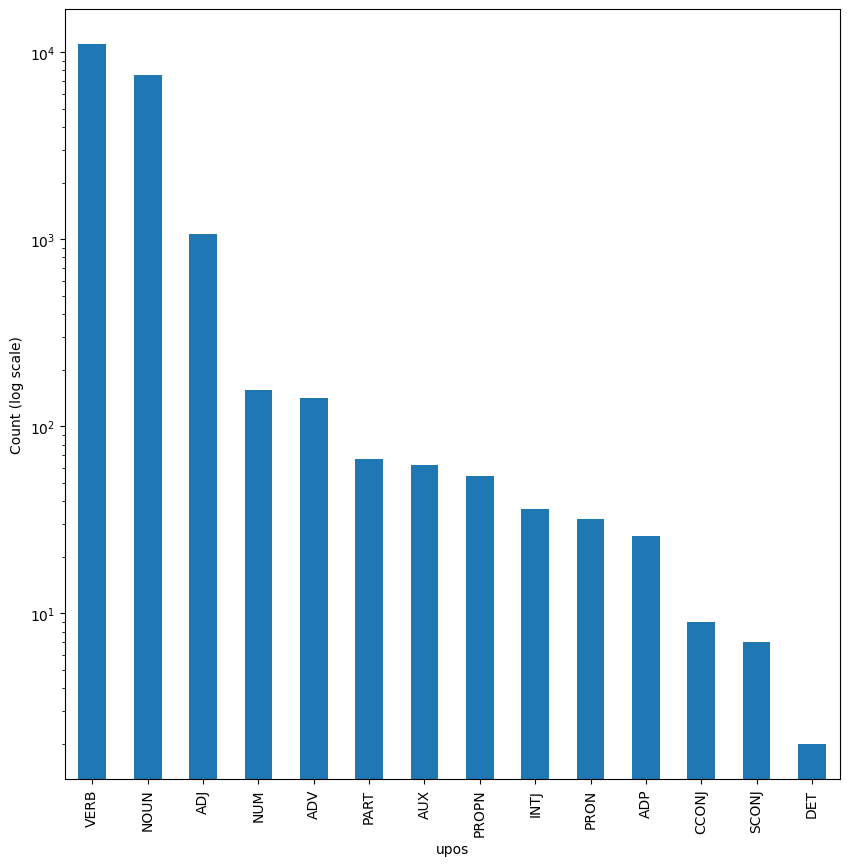

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each value in the column
value_counts = df["upos"].value_counts()

plt.figure(figsize=(10, 10))
value_counts.plot(kind="bar")

plt.yscale("log")  # ✅ log scale for y-axis

plt.xlabel("upos")
plt.ylabel("Count (log scale)")
plt.show()

In [ ]:
column_name = 'word'

# Find duplicate rows in that column
duplicates = df[df.duplicated(subset=[column_name], keep=False)]

# Count how many times each duplicated value appears
dup_counts = duplicates[column_name].value_counts()

print("Duplicate entries in column:", column_name)
print(dup_counts)

Duplicate entries in column: word
Series([], Name: count, dtype: int64)


# Dissimilation in the Bolinao Lexicon

# **Dissimilation in Bolinao**

In Bolinao, when the infix **-um-** or its completed form **-inum-** is inserted into a root word starting with a bilabial stop (p, b), the stop changes into a comparably voiced velar stop:

- **p → k**
- **b → g**

### Examples
- *babali* → *gumabali*  
- *bagyo* → *gumagyo*  
- *balasang* → *gumalasang*  
- *baya* → *gumaya*  
- *pa’sel* → *kuma’sel*  
- *padeg* → *kumedeg*  
- *puso’* → *kumuso’*  
- *puti’* → *kumuti’*  
- *piklo’* → *kumiklo’*  

The completed form of the infix **-um-** (→ **-inum-**) often reduces to **-inm-**, **-imm-**, or **-im-** in normal speech.

---

## 1. Data Exploration
We’ll load the Bolinao lexicon CSV, inspect it, and prep for processing.

In [ ]:
import pandas as pd

# Load your CSV
df = pd.read_csv("bolinao_lexicon.csv")
df.head()

,word,part_of_speech,meaning_english,meaning_filipino,sample_bolinao,sample_english,upos
0,a'lo,n,"Pestle, a rounded piece of wood about five inc...",Halo.,Kustoy byat nansi a'lonman'ipambayo kon irik.,Thepestlethat I am using to pound unhusked ric...,NOUN
1,a'nak,n,"Referring to specific children individually, n...",Mga anak.,Si Ligaya a kaka sa sarba konran syam nin a'na...,Ligaya is the oldest of Gorio's nine children.,NOUN
2,a'nem,n,"Six, the number following five.",Anim.,A'nem ray salay nan manok.,The chicken had six eggs.,NOUN
3,a'pat,n,Four.,Apat.,Nagbakasyon ako nin a'pat nin awro.,I took a vacation for four months.,NOUN
4,a'rong,n,Nose.,Ilong.,Say a'rong ran Pilipino ket ambo' tuloy nin ma...,The noses of Filipinos are not too pointed.,NOUN


## 2. Undoing Dissimilation Rules

We’ll create a function to generate possible root candidates for each dissimilation type.

In [ ]:
def undo_dissimilation(word):
    candidates = []

    # --- Infix -um- cases ---
    # If word starts with "gum", undo b->g
    if word.startswith("gum"):
        candidates.append("b" + word[3:])   # gumabali -> babali

    # If word starts with "kum", undo p->k
    if word.startswith("kum"):
        candidates.append("p" + word[3:])   # kumuti' -> puti'

    # Handle completed form reductions (-inum- → -im- / -imm- / -inm-)
    # We try to reconstruct by replacing im/imm/inm with inum
    if "imm" in word:
        candidates.append(word.replace("imm", "inum", 1))
    if "inm" in word:
        candidates.append(word.replace("inm", "inum", 1))
    if "im" in word:
        candidates.append(word.replace("im", "inum", 1))

    return list(set(candidates))


## 3. Cross-Checking with the Lexicon

Now we’ll test each word, generate candidates, and see if they exist in the lexicon with the same meaning.

In [ ]:
confirmed = []

for idx, row in df.iterrows():
    word = row['word']
    meaning = row['meaning_english']
    upos_dissimilation = row['upos']
    roots = undo_dissimilation(word)

    for r in roots:
        match = df[df['word'].str.strip() == r.strip()]
        if not match.empty:
            record = {
                "dissimilation": word,
                "root_candidate": r,
                "meaning_dissimilation": meaning,
                "meaning_root": "; ".join(match['meaning_english'].unique()),
                "upos_dissimilation": upos_dissimilation,
                "upos_root": "; ".join(match['upos'].unique())
            }
            confirmed.append(record)

confirmed_df = pd.DataFrame(confirmed)


## 4. Save Final Root Words

Export confirmed pairs for further linguistic analysis.

In [ ]:
confirmed_df.to_csv("bolinao_root_words_dissimilation.csv", index=False)
print("Saved to bolinao_root_words_dissimilation.csv")


Saved to bolinao_root_words_dissimilation.csv


# Assimilation in the Bolinao Lexicon

---

## **1. Assimilation in Bolinao**

Assimilation happens when affixes or clitics adjust their form to match the sounds they attach to. In Bolinao, it shows up in several places:

### **1.1 Verb affixes (maN-, aN-, saN-)**
- `man + bayo → mambayo`
- `man + ka + mati → mangkamati`
- `an + giling → manggiling`
- `saN- + kata’gayan → sangkata’gayan`

Rule: the **/n/** in maN-/aN-/saN- changes place of articulation to match the first consonant of the root.

---

### **1.2 Pronoun prefixes (koN-, ikon-)**
- `koN- + ta → konta`
- `ikon + ta → ikonta`
- `koN- + mi → komi`

Rule: the **/N/** assimilates to the first consonant of the pronoun root.

---

### **1.3 Deictic pronouns (iti, isen, itaw)**
- `mo + iti → modti`
- `mo + isen → modsen`
- `mo + itaw → modtaw`

Rule: encliticization turns the glottal + /i/ into **/d/**.

---

### **1.4 Linkers (a, nin)**
- `Mangansyon ya a anak → Mangansyon yay anak`
- `Aripen nako nin Dios → Aripen nakon Dios`

Rule: linker changes shape to **-y** or **-n** after vowel-final words.

---

## 1. Data Exploration
We’ll load the Bolinao lexicon CSV, inspect it, and prep for processing.

In [ ]:
import pandas as pd

# Load lexicon
df = pd.read_csv("bolinao_lexicon.csv")

# Quick look
print(df.head())
print(df.info())
print("Unique words:", df['word'].nunique())


     word part_of_speech                                    meaning_english  \
0    a'lo              n  Pestle, a rounded piece of wood about five inc...   
1   a'nak              n  Referring to specific children individually, n...   
2   a'nem              n                    Six, the number following five.   
3   a'pat              n                                              Four.   
4  a'rong              n                                              Nose.   

  meaning_filipino                                     sample_bolinao  \
0            Halo.      Kustoy byat nansi a'lonman'ipambayo kon irik.   
1        Mga anak.  Si Ligaya a kaka sa sarba konran syam nin a'na...   
2            Anim.                         A'nem ray salay nan manok.   
3            Apat.                Nagbakasyon ako nin a'pat nin awro.   
4           Ilong.  Say a'rong ran Pilipino ket ambo' tuloy nin ma...   

                                      sample_english  upos  
0  Thepestlethat I am usi

## 2. Undoing Assimilation Rules

We’ll create a function to generate possible root candidates for each assimilation type.

In [ ]:
def undo_assimilation(word: str):
    candidates = []

    # --- Verb affixes (maN-, aN-, saN-) ---
    if word.startswith("mamb"):
        candidates.append("b" + word[4:])    # mambayo -> bayo
    elif word.startswith("mamp"):
        candidates.append("p" + word[4:])
    elif word.startswith("mamm"):
        candidates.append("m" + word[4:])
    elif word.startswith("mang"):
        candidates.append("k" + word[4:])
    elif word.startswith("manng"):
        candidates.append("ng" + word[5:])
    elif word.startswith("man"):
        candidates.append(word[3:])          # fallback

    if word.startswith("an"):
        candidates.append(word[2:])          # an+root
    if word.startswith("san"):
        candidates.append(word[3:])          # san+root

    # --- Pronoun prefixes (koN-, ikon-) ---
    if word.startswith("kon"):
        candidates.append(word[3:])          # konta -> ta
    elif word.startswith("kom"):
        candidates.append("mi")              # komi -> mi
    elif word.startswith("iko"):
        candidates.append(word[2:])          # ikonra -> ra

    # --- Deictic pronouns ---
    if word.startswith("modtaw"):
        candidates.append("itaw")
    elif word.startswith("modt"):
        candidates.append("iti")             # modti -> iti
    elif word.startswith("mods"):
        candidates.append("isen")

    # --- Linkers (tightened) ---
    # Only undo linker if word is *short* (likely a particle) or clearly a linker form
    if len(word) <= 5:
        if word.endswith("y") and not word.endswith(("ay", "oy", "uy")):
            candidates.append(word[:-1] + " a")  # yay -> ya a
        if word.endswith("n") and not word.endswith(("an", "en", "on", "in")):
            candidates.append(word[:-1] + " nin")  # nakon -> nako nin

    return list(set(candidates))


## 3. Cross-Checking with the Lexicon

Now we’ll test each word, generate candidates, and see if they exist in the lexicon with the same meaning.

In [ ]:
confirmed = []

for idx, row in df.iterrows():
    word = row['word']
    meaning = row['meaning_english']
    upos_assimilated = row['upos']
    roots = undo_assimilation(word)

    for r in roots:
        match = df[df['word'].str.strip() == r.strip()]
        if not match.empty:
            record = {
                "assimilated": word,
                "root_candidate": r,
                "meaning_assimilated": meaning,
                "meaning_root": "; ".join(match['meaning_english'].unique()),
                "upos_assimilated": upos_assimilated,
                "upos_root": "; ".join(match['upos'].unique())
            }
            confirmed.append(record)

confirmed_df = pd.DataFrame(confirmed)

## 4. Save Final Root Words

Export confirmed pairs for further linguistic analysis.

In [ ]:
confirmed_df.to_csv("bolinao_root_words_assimilation.csv", index=False)

# Assimilation and Reduction in the Bolinao Lexicon

A process of assimilation and reduction occurs when prefixes ending in /ng/ (maNg-, naNg-, paNg-) attach to a word beginning with a stop or s (p, b, t, d, s, ', k, g). The /ng/ assimilates to the point of articulation and the initial consonant of the word is removed. Otherwise (words beginning with y, w, l, r, m, n, ng), the Ng remains as /ng/ and reduction does not take place. The tendency of ng to assimilate in this manner can also be found interword such as in compounding.


Rules:
*   maNg- + /p/ → ma- + m + reduced word
*   maNg- + /b/ → ma- + m + reduced word
*   naNg- + /p/ → na- + m + reduced word
*   naNg- + /b/ → na- + m + reduced word
*   paNg- + /p/ → pa- + m + reduced word
*   paNg- + /b/ → pa- + m + reduced word
------------------------------------------------
*   maNg- + /d/ → ma- + n + reduced word
*   maNg- + /t/ → ma- + n + reduced word
*   maNg- + /s/ → ma- + n + reduced word
*   naNg- + /d/ → na- + n + reduced word
*   naNg- + /t/ → na- + n + reduced word
*   naNg- + /s/ → na- + n + reduced word
*   paNg- + /d/ → pa- + n + reduced word
*   paNg- + /t/ → pa- + n + reduced word
*   paNg- + /s/ → pa- + n + reduced word
------------------------------------------------
*   maNg- + /k/ → ma- + ng + reduced word
*   maNg- + /g/ → ma- + ng + reduced word
*   maNg- + /'/ → ma- + ng + reduced word
*   naNg- + /k/ → na- + ng + reduced word
*   naNg- + /g/ → na- + ng + reduced word
*   naNg- + /'/ → na- + ng + reduced word
*   paNg- + /k/ → pa- + ng + reduced word
*   paNg- + /g/ → pa- + ng + reduced word
*   paNg- + /'/ → pa- + ng + reduced word
------------------------------------------------
*   maNg- + /not k, g, '/ → ma- + ng + unreduced word
*   naNg- + /not k, g, '/ → ma- + ng + unreduced word
*   paNg- + /not k, g, '/ → ma- + ng + unreduced word

Examples:
* mang + basa → mamasa “to read”
* mang + pa + ta’gay → mamata’gay “to go up”
* mang + saliw → manaliw “to buy”
* mang + kalap → mangalap “to get, remove”
* mang + aluyon → mangaluyon “to accompany”
* mang + lipot → manglipot “to give over”


## 1. Load and Prepare Data

This step loads the Excel-like file containing Bolinao words and prepares tools for text processing.

In [ ]:
import pandas as pd
import re

df = pd.read_csv("Bolinao Lexicon Final.csv", encoding='latin-1')

Filter only those starting with assimilation prefixes.

Words that starts with "mam", "man", "mang", "nam", "nan",  "nang", "pam", "pan", and "pang".

## 2. Filter Words with Assimilation Prefixes

This step filters the dataset to include only those words starting with the assimilation prefixes: "mam", "man", "mang", "nam", "nan", "nang", "pam", "pan", and "pang".

In [ ]:
candidates = df[df["word"].str.startswith(("mam", "man", "mang", "nam", "nan",  "nang", "pam", "pan", "pang"), na=False)].copy()

## 3. Define Root Word Recovery Function

This function is designed to reverse the sound changes caused by assimilation and reduction, aiming to find the original root word before prefixes were added.

In [ ]:
# Define assimilation + reduction rules
def undo_assimilation_reduction(word):
    original = word
    process = []
    formula = []
    root = word  # default if no change

    if word.startswith("mang"):
        rest = word[4:]
        if rest and rest[0] in ["y", "w", "l", "r", "m", "n"]:  # y/w/l/r/m/n root
            root = rest
            process.append("no reduction")
            formula.append("mang- with root starting y/w/l/r/m/n/ng (ng stays)")
        else:  # k, g, ' root
            root = "k" + rest + "|" + "g" + rest + "|" + "'" + rest + "|" + rest
            process.append("assimilation+reduction|no reduction for a/e/i/o/u")
            formula.append("mang- + (k/g/' root (consonant dropped, ng kept)|mang- with root starting a/e/i/o/u (ng stays))")

    elif word.startswith("mam"):  # mang- + p/b root
        root = "b" + word[3:] + "|" + "p" + word[3:]
        process.append("assimilation+reduction")
        formula.append("mam- from mang- + p/b root (p/b dropped, ng→m)")

    elif word.startswith("man"):  # mang- + t/d/s root
        root = "s" + word[3:] + "|" + "t" + word[3:] + "|" + "d" + word[3:]
        process.append("assimilation+reduction")
        formula.append("man- from mang- + t/d/s root (consonant dropped, ng→n)")

    elif word.startswith("nang"):
        rest = word[4:]
        if rest and rest[0] in ["y", "w", "l", "r", "m", "n"]:  # y/w/l/r/m/n root
            root = rest
            process.append("no reduction")
            formula.append("nang- with root starting y/w/l/r/m/n/ng (ng stays)")
        else:  # k, g, ' root
            root = "k" + rest + "|" + "g" + rest + "|" + "'" + rest + "|" + rest
            process.append("assimilation+reduction|no reduction for a/e/i/o/u")
            formula.append("nang- + (k/g/' root (consonant dropped, ng kept)|nang- with root starting a/e/i/o/u (ng stays))")

    elif word.startswith("nam"):  # nang- + p/b root
        root = "b" + word[3:] + "|" + "p" + word[3:]
        process.append("assimilation+reduction")
        formula.append("nam- from nang- + p/b root (p/b dropped, ng→m)")

    elif word.startswith("nan"):  # nang- + t/d/s root
        root = "s" + word[3:] + "|" + "t" + word[3:] + "|" + "d" + word[3:]
        process.append("assimilation+reduction")
        formula.append("nan- from nang- + t/d/s root (consonant dropped, ng→n)")

    elif word.startswith("pang"):
        rest = word[4:]
        if rest and rest[0] in ["y", "w", "l", "r", "m", "n"]:  # y/w/l/r/m/n root
            root = rest
            process.append("no reduction")
            formula.append("pang- with root starting y/w/l/r/m/n/ng (ng stays)")
        else:  # k, g, ' root
            root = "k" + rest + "|" + "g" + rest + "|" + "'" + rest + "|" + rest
            process.append("assimilation+reduction|no reduction for a/e/i/o/u")
            formula.append("pang- + (k/g/' root (consonant dropped, ng kept)|pang- with root starting a/e/i/o/u (ng stays))")

    elif word.startswith("pam"):  # pang- + p/b root
        root = "b" + word[3:] + " |" + "p" + word[3:]
        process.append("assimilation+reduction")
        formula.append("pam- from pang- + p/b root (p/b dropped, ng→m)")

    elif word.startswith("pan"):  # pang- + t/d/s root
        root = "s" + word[3:] + "|" + "t" + word[3:] + "|" + "d" + word[3:]
        process.append("assimilation+reduction")
        formula.append("pan- from pang- + t/d/s root (consonant dropped, ng→n)")

    else:
        process.append("unchanged")
        formula.append("does not match assimilation/reduction patterns")

    return pd.Series({
        "word": original,
        "root_word": root,
        "process": ", ".join(process),
        "formula": "; ".join(formula)
    })


## 4. Apply Root Word Recovery

This step applies the `undo_assimilation_reduction` function to each word identified in Step 3 to generate potential root word candidates.

In [ ]:
results_df = candidates["word"].dropna().apply(undo_assimilation_reduction)

## 5. Combine Original Data with Analysis

This step merges the original word data (including meaning and part of speech) with the results of the root word analysis. The resulting data includes the columns: "word", "upos", "meaning_english", "root_word", "process", and "formula".

In [ ]:
results_full = candidates[["word", "upos"]].merge(
    results_df, left_on="word", right_on="word"
)

## 6. Verify Root Word Candidates

This step checks if the predicted root words generated in Step 5 actually exist in the original dictionary and whether their meanings align with the assimilated/reduced words.

In [ ]:
confirmed = []

for idx, row in results_full.iterrows():
    word = row['word']
    meaning = row['meaning_english']
    upos_assimilated_reduced = row['upos']
    roots = row['root_word'].split('|')  # Split multiple root candidates

    for r in roots:
        r = r.strip()  # Remove extra spaces
        # Look for exact matches in the lexicon
        match = df[df['word'].str.strip() == r.strip()]
        if not match.empty:
            record = {
                "assimilated": word,
                "root_candidate": r,
                "meaning_assimilated_reduced": meaning,
                "meaning_root": "; ".join(match['meaning_english'].unique()),
                "upos_assimilated_reduced": upos_assimilated_reduced,
                "upos_root": "; ".join(match['upos'].unique()) if 'upos' in match.columns else "; ".join(match['part_of_speech'].unique())
            }
            confirmed.append(record)

confirmed_df = pd.DataFrame(confirmed)

## 7. Export Results

This step saves the confirmed root words and their corresponding information to a CSV file for further analysis or use.

In [ ]:
confirmed_df.to_csv("bolinao_root_words_assimilation_and_reduction.csv", index=False)

# Gemination in Bolinao Lexicon

### **Source:** Webonary Bolinao Dictionary

Gemination refers to consonant doubling in Bolinao.
It normally results from vowel syncopation (loss of a vowel between consonants).

Examples include:

- sinomobliq → sinmobliq “returning”

- tinomombok → timmombok “following”

- makakaqlis → makkaqlis “is laughing”

- alalaki → allaki “bigger”

Gemination typically involves pp, tt, dd, kk, gg, mm, nn, ll, rr, yy, but younger speakers may not pronounce the doubled consonant, leading to reduction instead.


**1. Load Dataset**
---
Rule/Process: We load the dataset with:

> word → surface form









In [ ]:
import pandas as pd
import re

df = pd.read_csv("/content/Bolinao Lexicon - bolinao_lexicon_final (1).csv")
df.head()

,word,part_of_speech,meaning_english,meaning_filipino,sample_bolinao,sample_english,upos
0,a'lo,n,"Pestle, a rounded piece of wood about five inc...",Halo.,Kustoy byat nansi a'lonman'ipambayo kon irik.,Thepestlethat I am using to pound unhusked ric...,NOUN
1,a'nak,n,"Referring to specific children individually, n...",Mga anak.,Si Ligaya a kaka sa sarba konran syam nin a'na...,Ligaya is the oldest of Gorio's nine children.,NOUN
2,a'nem,n,"Six, the number following five.",Anim.,A'nem ray salay nan manok.,The chicken had six eggs.,NOUN
3,a'pat,n,Four.,Apat.,Nagbakasyon ako nin a'pat nin awro.,I took a vacation for four months.,NOUN
4,a'rong,n,Nose.,Ilong.,Say a'rong ran Pilipino ket ambo' tuloy nin ma...,The noses of Filipinos are not too pointed.,NOUN


## **2. Detect Gemination**

### **Code implementation:**

If a word contains doubled consonants (pp, tt, …), we collapse them to a single consonant to reconstruct a possible root.

Example in our dataset:

- Input: allaki
- Guess: alalaki
- Confirmed: alalaki.

In [ ]:
geminate_consonants = ["pp","tt","dd","kk","gg","mm","nn","ll","rr","yy"]

def detect_gemination(word):
    for g in geminate_consonants:
        if g in word:
            collapsed = word.replace(g, g[0], 1)
            return [collapsed]
    return None


# Reduction in Bolinao lexicon

> Reduction occurs when a vowel is dropped, especially between -in- and -om- infixes or inside reduplicated sequences.

>Example patterns:

- tinomombok → timmombok

- sibibibyay → sibibbyay

- makakaqlis → makkaqlis

## **Code implementation:**
> Detect consonant clusters and attempt to restore the missing vowel.

> Vowel choice depends on surrounding consonants:

- after n/m → o (sometimes i)

- after l/k/q → a

- after b/p → i

- otherwise → a or o

> Example in our dataset:

- Input: sinmobliq

- Guess: sinomobliq / sinimobliq

- Confirmed: sinomobliq (if in dictionary).

In [ ]:
def restore_vowels(cluster):
    c1, c2 = cluster[0], cluster[1]
    options = []
    if c1 in ["n","m"]:
        options.extend([c1 + "o" + c2, c1 + "i" + c2])
    elif c1 in ["l","k","q"]:
        options.append(c1 + "a" + c2)
    elif c1 in ["b","p"]:
        options.append(c1 + "i" + c2)
    else:
        options.extend([c1 + "a" + c2, c1 + "o" + c2])
    return options

def detect_reduction(word):
    pattern = r"([bcdfghjklmnpqrstvwxyz])([bcdfghjklmnpqrstvwxyz])"
    match = re.search(pattern, word)
    if match:
        cluster = match.group(0)
        roots = []
        for restored in restore_vowels(cluster):
            roots.append(word.replace(cluster, restored, 1))
        return list(set(roots))
    return None


## **4. Root Word Candidate Evaluation**

> **Rule/Process:** Collect guesses from gemination & reduction and check if any match dictionary.

> Example:

- Input: timmombok

- Guess: tinomombok

- Confirmed: tinomombok.

In [ ]:
lexicon = set(df["word"].dropna().astype(str).str.lower())

def get_root(word, lexicon):
    guesses, confirmed = [], []

    gem = detect_gemination(word)
    if gem:
        guesses.extend(gem)
        confirmed.extend([g for g in gem if g in lexicon])

    red = detect_reduction(word)
    if red:
        guesses.extend(red)
        confirmed.extend([r for r in red if r in lexicon])

    if not guesses:
        return "n/a", "n/a"

    return "/".join(guesses), "/".join(set(confirmed)) if confirmed else "n/a"


## **5. Apply to Dataset & Save Results**

In [ ]:
# Apply the root detection and keep the 'word' column
results = []

for idx, w in enumerate(df["word"].astype(str)):
    guess, confirmed = get_root(w.lower(), lexicon)

    if idx < 10:
        print(f"Word: {w}")
        print(f"  → Root guess: {guess}")
        print(f"  → Confirmed: {confirmed}")
        print("-" * 40)

    results.append({
        "word": w,
        "root_word_guess": guess,
        "root_word_confirmed": confirmed
    })

# Convert back to DataFrame
final_df = pd.DataFrame(results, columns=["word", "root_word_guess", "root_word_confirmed"])

# Save results
final_df.to_csv("bolinao_gemination_reduction_results.csv", index=False)

# Preview first 20 rows
final_df.head(20)


Word: a'lo
  → Root guess: n/a
  → Confirmed: n/a
----------------------------------------
Word: a'nak
  → Root guess: n/a
  → Confirmed: n/a
----------------------------------------
Word: a'nem
  → Root guess: n/a
  → Confirmed: n/a
----------------------------------------
Word: a'pat
  → Root guess: n/a
  → Confirmed: n/a
----------------------------------------
Word: a'rong
  → Root guess: a'ronig/a'ronog
  → Confirmed: n/a
----------------------------------------
Word: a'song
  → Root guess: a'sonig/a'sonog
  → Confirmed: n/a
----------------------------------------
Word: a'su-a'song
  → Root guess: a'su-a'sonog/a'su-a'sonig
  → Confirmed: n/a
----------------------------------------
Word: aabriwan
  → Root guess: aabiriwan
  → Confirmed: n/a
----------------------------------------
Word: aadyan
  → Root guess: aadayan/aadoyan
  → Confirmed: n/a
----------------------------------------
Word: aak
  → Root guess: n/a
  → Confirmed: n/a
----------------------------------------


,word,root_word_guess,root_word_confirmed
0,a'lo,n/a,n/a
1,a'nak,n/a,n/a
2,a'nem,n/a,n/a
3,a'pat,n/a,n/a
4,a'rong,a'ronig/a'ronog,n/a
5,a'song,a'sonig/a'sonog,n/a
6,a'su-a'song,a'su-a'sonog/a'su-a'sonig,n/a
7,aabriwan,aabiriwan,n/a
8,aadyan,aadayan/aadoyan,n/a
9,aak,n/a,n/a


## **6. Extract the Geminated/Reduced and their Confirmed Root Words**

In [ ]:
import pandas as pd
import os

results_path = "/content/bolinao_gemination_reduction_results.csv"   # with confirmed roots
lexicon_path = "/content/Bolinao Lexicon - bolinao_lexicon_final (1).csv"  # main lexicon
output_path = "/content/bolinao_gemination_reduction_analysis.csv"  # new output file

results_df = pd.read_csv(results_path, dtype=str).fillna('')
lex_df = pd.read_csv(lexicon_path, dtype=str).fillna('')

def normalize_word(w):
    if pd.isna(w):
        return ''
    return str(w).replace("’", "'").strip().lower()

results_df['word_norm'] = results_df['word'].apply(normalize_word)
lex_df['word_norm'] = lex_df['word'].apply(normalize_word)

def lookup_meaning_upos(word_norm):
    if not word_norm:
        return "n/a", "n/a"
    row = lex_df[lex_df['word_norm'] == word_norm]
    if not row.empty:
        meaning = row.iloc[0].get('meaning_english', '') or "n/a"
        upos = row.iloc[0].get('upos', '') or "n/a"
        return meaning, upos
    return "n/a", "n/a"

out_rows = []
for _, r in results_df.iterrows():
    confirmed_raw = str(r['root_word_confirmed']).strip()
    if confirmed_raw.lower() in ("", "n/a"):
        continue  # skip if no confirmed root

    # pick the first candidate that exists in lexicon
    candidates = [normalize_word(c) for c in confirmed_raw.split('/')]
    chosen_root = None
    for cand in candidates:
        if cand in lex_df['word_norm'].values:
            chosen_root = cand
            break

    if not chosen_root:
        continue  # skip if no candidate found in lexicon

    orig_word = r['word']
    orig_norm = r['word_norm']

    # Look up meaning & UPOS
    orig_meaning, orig_upos = lookup_meaning_upos(orig_norm)
    root_meaning, root_upos = lookup_meaning_upos(chosen_root)

    out_rows.append({
        "Geminated/Reduced": orig_word,
        "Root Candidate": chosen_root,
        "Meaning of the Geminated/Reduced Word": orig_meaning,
        "Meaning of the Confirmed Root Word": root_meaning,
        "UPOS of Geminated/Reduced word": orig_upos,
        "UPOS of the Confirmed Root Word": root_upos
    })

out_df = pd.DataFrame(out_rows, columns=[
    "Geminated/Reduced",
    "Root Candidate",
    "Meaning of the Geminated/Reduced Word",
    "Meaning of the Confirmed Root Word",
    "UPOS of Geminated/Reduced word",
    "UPOS of the Confirmed Root Word"
])

os.makedirs(os.path.dirname(output_path) or ".", exist_ok=True)
out_df.to_csv(output_path, index=False, encoding="utf-8")

print(f"Saved {len(out_df):,} rows to {output_path}")
out_df.head(10)


Saved 122 rows to /content/bolinao_gemination_reduction_analysis.csv


,Geminated/Reduced,Root Candidate,Meaning of the Geminated/Reduced Word,Meaning of the Confirmed Root Word,UPOS of Geminated/Reduced word,UPOS of the Confirmed Root Word
0,agwa,agawa,Perfume water.,Diligence combined with promptness.,NOUN,NOUN
1,alla,ala,Watch out! An exclamation used to warn or thre...,Go! To command someone to get moving.,INTJ,INTJ
2,arkan,arakan,To kiss or touch with the cheek or lips on the...,To flock to something.,VERB,VERB
3,bakbak,bakabak,A fight between dogs or pigs that are biting.,A dry wood termite that produces frass or pell...,NOUN,NOUN
4,baraybay,barayabay,The surroundings of a house or structure.,"Anything that flows down the face - tears, sweat.",NOUN,NOUN
5,barbar,barabar,The act of exposing to rain or liquid for a lo...,Stick for barbecuing.,NOUN,NOUN
6,barbaren,barabaren,To leave something to soak in a liquid.,For someone to insert a stick into a piece of ...,VERB,VERB
7,basbas,basabas,Memorial service for the dead on the first yea...,The second processing when the essence of the ...,NOUN,NOUN
8,baybay,bayabay,The area of water next to the land or the shal...,Support usually along a stair case or a bridge...,NOUN,NOUN
9,blangen,bilangen,To split wood with the grain using an ax or he...,To calculate or count out something.,VERB,VERB


## **Edge Case Notes (with Examples)**

---

### **1. False Gemination**
Words with double consonants but the confirmed root is the same as the word.  
These look like gemination but are actually natural forms (e.g., borrowed words or expressive forms).  

- **Example:** `sallamat` → root `sallamat` (no real gemination)  

---

### **2. Ambiguous Vowel Restoration**
Cases where multiple possible root candidates exist after restoring a vowel.  
The script lists several options, but typically only the first candidate is picked.  

- **Example:** `sinmobliq` → root candidates `sinomobliq / sinimobliq`  

---

### **3. Reduplication Overlaps**
Some words contain triplet consonants (e.g., `bbb`, `ppp`) or repetitive clusters.  
This may be mistaken for gemination or reduction, when in reality it comes from reduplication.  

- **Example:** `sibibbyay` → root candidate `sibibibyay`  

---

### **4. Generational Variation**
Variation in pronunciation across generations can affect consonant length.  
Some forms reduce geminates, while others retain them, leading to alternate roots.  

- **Example:** `timmombok` → root `timombok`  

---

### **5. Apostrophe Handling**
Apostrophes (`'` or `’`) can signal glottal stops or morpheme boundaries.  
The algorithm may misinterpret these and attempt incorrect restoration.  

- **Example:** `a'lon` → root `alon`  
- **Example:** `man'ipambayo` → root `bayo`  

---

### **6. Affixation Effects**
Clusters introduced by prefixes or infixes (e.g., *man-*, *pan-*, *san-*) may appear as reduction but are not.  

- **Example:** `manluto` (root `luto`) → `nl` cluster is due to prefix *man-*  

---

### **7. Multiple Confirmed Roots**
A word may correspond to more than one confirmed root candidate.  
The script currently lists them, but only the first candidate is typically chosen for downstream use.  

- **Example:** `man'ipambayo` → confirmed roots `pambayo / bayo`  

---


In [ ]:
import pandas as pd

df = pd.read_csv("bolinao_gemination_reduction_analysis.csv")

edge_cases = []

# 1. False Gemination: words with double consonants but confirmed root = same as word
for _, row in df.iterrows():
    word = row["Geminated/Reduced"]
    root = str(row["Root Candidate"])
    if any(cc in word for cc in ["pp","tt","dd","kk","gg","mm","nn","ll","rr","yy"]):
        if word == root:
            edge_cases.append(["False Gemination", word, root, "Looks like gemination but natural", "Borrowed/expressive form"])

# 2. Ambiguous Vowel Restoration: multiple roots listed
for _, row in df.iterrows():
    if "/" in str(row["Root Candidate"]):
        edge_cases.append(["Ambiguous Vowel Restoration", row["Geminated/Reduced"], row["Root Candidate"], "Multiple possible vowels", "Picked first candidate"])

# 3. Reduplication Overlaps: word contains triplet consonant like 'bbb', 'ppp' or repetitive cluster
for _, row in df.iterrows():
    word = row["Geminated/Reduced"]
    if any(rep*3 in word for rep in ["b","p","t","d","k","g","m","n","l","r","y"]):
        edge_cases.append(["Reduplication Overlaps", word, row["Root Candidate"], "Cluster caused by reduplication", "Hard to separate from reduction"])

# 4. Generational Variation: word root differs by one consonant length
for _, row in df.iterrows():
    word, root = str(row["Geminated/Reduced"]), str(row["Root Candidate"])
    if word != root and word.replace("mm","m") == root:
        edge_cases.append(["Generational Variation", word, root, "Variant form not always in lexicon", "Modern vs. older form"])

# 5. Apostrophe Handling
for _, row in df.iterrows():
    if "'" in str(row["Geminated/Reduced"]) or "’" in str(row["Geminated/Reduced"]):
        edge_cases.append(["Apostrophe Handling", row["Geminated/Reduced"], row["Root Candidate"], "Apostrophe normalization issue", "Unicode vs ASCII"])

# 6. Affixation Effects: cluster caused by prefix (e.g., man-, pan-)
for _, row in df.iterrows():
    word = str(row["Geminated/Reduced"])
    if word.startswith(("man","pan","san")) and "n" in word[3:5]:
        edge_cases.append(["Affixation Effects", word, row["Root Candidate"], "Cluster due to affix", "Not actual reduction"])

# 7. Multiple Confirmed Roots
for _, row in df.iterrows():
    if "/" in str(row["Root Candidate"]):
        edge_cases.append(["Multiple Confirmed Roots", row["Geminated/Reduced"], row["Root Candidate"], "More than one root candidate", "Script only picks first"])

edge_cases_df = pd.DataFrame(edge_cases, columns=["Edge Case", "Example Word", "Confirmed Root Candidate", "Issue Observed", "Notes"])
edge_cases_df.to_csv("bolinao_edge_case_examples.csv", index=False)

print("Edge case examples saved as bolinao_edge_case_examples.csv")


Edge case examples saved as bolinao_edge_case_examples.csv


# Number or Mass Indication in Bolinao Lexicon

This notebook demonstrates how **Bolinao words** show number or mass indication based on linguistic rules and also attempts to recover the **root word**.

### 2.2 Number or Mass Indication Rules
Number or mass are indicated through:

1. **General sense of the word**
2. **Reduplication** (repeating part of the root word)
3. **Use of pronouns** to accompany the word
4. **Infixation of `-aw-` / `-u-`**

👉 Example transformations:
- *bato* → *bubato* / *bawbato* ('group of stones')
- *anak* → *uanak* / *awanak* ('group of children')
- *baboy* → *bubaboy* / *bawbaboy* ('group of pigs')

### Special cases:
- Gemination (sound doubling with vowel reduction):
  - *lalaki* → *lulalaki* → *lullaki* ('group of men')
  - *babayi* → *bubabayi* → *bubbiyi* ('group of women')
- Extended noun forms through reduplication of consonant + vowel:
  - *anak* → *aanak* → *a’nak* ('children')



## 🔽 Define Detection and Root Extraction Rules

We implemented regex- and condition-based rules to identify number/mass indication and extract **rootword candidates**. The function `detect_and_extract` applies the following rules:

1. **Gemination (lulalaki → lalaki, bubbiyi → babayi)**  
   - If the word contains the infix `-u-` and the 2nd, 3rd, and 4th characters are reduplicated forms of the initial consonant, we replace the `u` with `a` and collapse the geminated sequence.  
   - Example:  
     - *lulalaki* → *lalaki*  
     - *bubbiyi* → *babayi*  

2. **Skip Rule: Two-syllable reduplication**  
   - If a word is formed by repeating a two-syllable sequence (e.g., `abab`, `bibi`, `lolo`), no stemming is applied.  
   - These are full reduplications, not mass indicators.  

3. **Initial Gemination / CV Reduplication (aanakan → anakan)**  
   - If the word begins with two identical consonants or vowels, the extra character is dropped.  
   - Example: *aanakan* → *anakan*  

4. **Consonant-Vowel (CV) Reduplication (bubato → bato, bubaboy → baboy)**  
   - If the first two letters (a CV sequence) are repeated, we remove the reduplicated CV.  
   - Example:  
     - *bubato* → *bato*  
     - *bubaboy* → *baboy*  

5. **Simple reduplication (fallback rule)**  
   - If none of the above match but the first character is reduplicated, we drop the repeated consonant.  
   - Example: *bubato* → *bato*  

In [ ]:
def detect_and_extract(word, lexicon):
    """
    Detects number/mass indication and attempts to extract a rootword candidate.
    Returns:
        (root_candidate, applied_stemming, process)
    """

    root_candidate = None
    applied_stemming = "no"
    process = "None"

    # Special rule: lullaki → lalaki
    if (len(word) >= 4 and word[1] == "u" and word[2] == word[0] and word[3] == word[2]):
      root_candidate = word[0] + "a" + word[3:]  # replace "uX" with "a"
      applied_stemming = "yes"
      process = "Gemination (lulalaki → lalaki)"
      print(f"[LOG] {word} → {root_candidate} | Rule: {process}")

    elif len(word) % 2 == 0 and word[:len(word)//2] == word[len(word)//2:]:
      print(f"[LOG] Skipping {word} (two-syllable reduplication)")

    # Rule 1: Reduplication of Consonant vowel
    elif re.match(r"^(\w)\1", word):
        root_candidate = re.sub(r"^(\w)\1", r"\1", word)
        applied_stemming = "yes"
        process = "CV Reduplication First Letter"
        print(f"[LOG] {word} → {root_candidate} | Rule: {process}")

    # Rule 1: Reduplication of Consonant Vowel
    elif re.match(r"^(.{2})\1", word):
        root_candidate = word[2:]  # remove reduplicated CV
        applied_stemming = "yes"
        process = "CV Reduplication"
        print(f"[LOG] {word} → {root_candidate} | Rule: {process}")

    # Rule 2: Simple reduplication (bubato → bato)
    elif re.match(r"^(\w)\1", word):
        root_candidate = word[2:]  # drop the reduplicated consonant
        applied_stemming = "yes"
        process = "Reduplication"
        print(f"[LOG] {word} → {root_candidate} | Rule: {process}")

    return root_candidate, applied_stemming, process


### 🔽 Step 4: Detection and Rootword Verification

After defining the detection rules, these were systematically applied to each word in the dataset.
The rules identify morphological processes such as reduplication, infixation, or gemination.
When a process was detected, a rootword candidate was extracted and subsequently verified against the lexicon.  

Only cases that satisfied two conditions were retained in the results table:  
1. The word underwent at least one detectable morphological process.  
2. The extracted rootword candidate was present in the lexicon.  

This filtering ensured that the analysis focused solely on linguistically valid forms, excluding surface words without clear morphological alternations or candidates lacking lexical evidence.  

The results table includes the following columns:  

- **original_word** → the observed surface form  
- **rootword_candidate** → the extracted rootword candidate (must exist in the lexicon)  
- **meaning_original** → English gloss of the surface form  
- **meaning_candidate** → English gloss of the verified root candidate (from lexicon)  
- **upos_original** → part-of-speech tag of the original word  
- **upos_candidate** → part-of-speech tag of the root candidate (from lexicon)  


In [ ]:
results = []

# Build lookup for lexicon words → meanings and UPOS
lexicon_dict = dict(zip(df["word"], zip(df["meaning_english"], df["upos"])))

for _, row in df.iterrows():
    word = row["word"]
    meaning_original = row["meaning_english"]
    upos_original = row["upos"]

    # Detect and extract
    root_candidate, applied_stemming, process = detect_and_extract(word, df["word"].tolist())

    # Only include if processing/stemming was applied AND root candidate exists in lexicon
    if applied_stemming == "yes" and root_candidate in lexicon_dict:
        meaning_candidate, upos_candidate = lexicon_dict[root_candidate]

        results.append({
            "original_word": word,
            "rootword_candidate": root_candidate,
            "meaning_original": meaning_original,
            "meaning_candidate": meaning_candidate,
            "upos_original": upos_original,
            "upos_candidate": upos_candidate
        })

results_df = pd.DataFrame(results)

# Replace NaN with empty string for clean CSV
results_df = results_df.fillna("")


[LOG] aabriwan → abriwan | Rule: CV Reduplication First Letter
[LOG] aadyan → adyan | Rule: CV Reduplication First Letter
[LOG] aak → ak | Rule: CV Reduplication First Letter
[LOG] aanakan → anakan | Rule: CV Reduplication First Letter
[LOG] Skipping abab (two-syllable reduplication)
[LOG] ababo → abo | Rule: CV Reduplication
[LOG] ababwen → abwen | Rule: CV Reduplication
[LOG] adado → ado | Rule: CV Reduplication
[LOG] adadwen → adwen | Rule: CV Reduplication
[LOG] alalay → alay | Rule: CV Reduplication
[LOG] Skipping anan (two-syllable reduplication)
[LOG] ananen → anen | Rule: CV Reduplication
[LOG] arara' → ara' | Rule: CV Reduplication
[LOG] ararak → arak | Rule: CV Reduplication
[LOG] ararem → arem | Rule: CV Reduplication
[LOG] ararmen → armen | Rule: CV Reduplication
[LOG] Skipping ba'ba' (two-syllable reduplication)
[LOG] Skipping baba (two-syllable reduplication)
[LOG] babaen → baen | Rule: CV Reduplication
[LOG] babag'ungen → bag'ungen | Rule: CV Reduplication
[LOG] babalata

## 🔽 Step 5: View Results
We will display the table of all words that were processed and their corrseponding meanings and upos together with the extracted rootword and also their corresponding meaning and upos if it exists in the original lexicon


In [ ]:
# Save final CSV with only the required columns
results_df.to_csv("rootword-number-or-mass-indication-removal.csv", index=False)

print(f"Results saved to rootword-number-or-mass-indication-removal.csv")



Results saved to rootword-number-or-mass-indication-removal.csv


## Block 1: Import & Load Data  

We begin by importing the necessary libraries:  

- `pandas` → for data wrangling  
- `re` → for regex (used later in word processing)  

Then we load the **finalized Bolinao lexicon** CSV file.  

This dataset contains:  
- the surface form (`word`),  
- part-of-speech tags (`part_of_speech`, `upos`),  
- English and Filipino glosses (`meaning_english`, `meaning_filipino`),  
- plus other lexical metadata.  

In [ ]:
import pandas as pd
import re

# Load the finalized Bolinao lexicon
bolinao_final = pd.read_csv("Bolinao Lexicon - bolinao_lexicon_final.csv")

## Block 2: Filter Relevant Pronoun Categories  

Following **Persons (1980, rev. 2025)** *Bolinao Morphophonemics*,  
we focus only on pronoun types relevant to morphophonemic alternations:  

- **interrogative pronouns** (*intrg pron*)  
- **indefinite pronouns** (*indfpro*)  
- **demonstrative pronouns** (*DPr*)  
- **expletives** (*expl*)  

All other lexical categories are excluded in this step.  

In [ ]:
valid_pronouns = ["intrg pron", "indfpro", "DPr", "expl"]

pronoun_entries = bolinao_final[
    bolinao_final["part_of_speech"].isin(valid_pronouns)
]

## Block 3: Select Useful Columns  

From the lexicon we keep only the most relevant fields:  

- `word` → surface form  
- `part_of_speech` → detailed grammatical role  
- `upos` → universal POS tag (for cross-linguistic comparison)  
- `meaning_english` → English gloss  
- `meaning_filipino` → Filipino gloss  

This reduces noise and prepares the dataset for morphophonemic analysis.  

In [ ]:
pronoun_clean = pronoun_entries[[
    "word", "part_of_speech", "upos", "meaning_english", "meaning_filipino"
]].reset_index(drop=True)

## Block 4: Define Root Extraction Rules  

We now implement morphophonemic rules from **Persons (1980, rev. 2025)**.  

### Interrogative Pronouns  
- *ansaray-* → *saray-* (prefix *an-* dropped)  
- *ansai-*, *ansara-*, *ansi-* → drop *an-* prefix  
- *ansay-* → *say-*  

### Indefinite Pronouns  
- Reduplicated forms remain unchanged (e.g., *inin → inin*).  
- This follows §2.2 (reduplication as marker of indefiniteness/mass).  

### Demonstrative Pronouns  
- Variants arise from **cliticization and linker alternations**:  
  - *modti*, *moyti* → *iti*  
  - *modsen* → *isen*  
  - *modtaw* → *itaw*  
  - *moytaw* → *taw*  
- These reflect the processes described in **§Deictic Pronouns and Linkers**.  

### Expletives  
- Left unchanged, as no morphophonemic alternations apply.  

In [ ]:
def get_root_pronoun(word: str, pos: str) -> str:
    original = word.strip().lower()

    # --- Interrogatives ---
    if pos == "intrg pron":
        if original.startswith("ansaray"):
            return "saray" + original[len("ansaray"):]
        if original.startswith(("ansai", "ansara", "ansi")):
            return original[2:]  # strip "an"
        if original.startswith("ansay"):
            return "say" + original[len("ansay"):]
        return original

    # --- Indefinites ---
    if pos == "indfpro":
        # Reduplication is semantically integral, so keep as-is
        return original

    # --- Demonstratives ---
    if pos == "DPr":
        demo_map = {
            "moyti": "iti", "modti": "iti",
            "moin": "in", "modsen": "isen",
            "moytaw": "taw", "modtaw": "itaw",
        }
        if original in demo_map:
            return demo_map[original]
        return original

    # --- Expletives ---
    if pos == "expl":
        return original

    # --- koN-/ikon- supportive pronouns ---
    kon_map = {
        "kongko": "ko", "ikongko": "ko",
        "konta": "ta", "ikonta": "ta",
        "kontamo": "tamo", "ikontamo": "tamo",
        "komi": "mi", "ikomi": "mi",
        "komo": "mo", "ikomo": "mo",
        "komoyo": "moyo", "ikomoyo": "moyo",
        "kona": "na", "ikona": "na",
        "konra": "ra", "ikonra": "ra",
    }
    if original in kon_map:
        return kon_map[original]

    # --- Linker alternations (a/-y, nin/-n) ---
    # Strip linker -y/-n only if it looks like an alternated form
    if original.endswith("y") and len(original) > 2:
        return original[:-1]  # remove -y
    if original.endswith("n") and len(original) > 2:
        return original[:-1]  # remove -n

    # --- Fallback ---
    return original

## Block 5: Apply Root Extraction  

We apply the morphophonemic rules to each pronoun in the dataset.  
A new column `root_word` is created that holds the extracted root form.  

In [ ]:
pronoun_clean["root_word"] = pronoun_clean.apply(
    lambda row: get_root_pronoun(row["word"], row["part_of_speech"]), axis=1
)

## Block 6: Display Final Results  

Finally, we configure Pandas to show all rows and columns.  
We then display a compact table with:  

- the surface pronoun (`word`)  
- its morphophonemic root (`root_word`)  
- its part of speech (`part_of_speech`)  
- its English gloss (`meaning_english`)  

This lets us check whether the extracted roots align with the rules in  
**Bolinao Morphophonemics** (Persons 1980, rev. 2025).  

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

pronoun_clean[["word", "root_word", "part_of_speech", "meaning_english"]]

,word,root_word,part_of_speech,meaning_english
0,adti,adti,intrg pron,"Identifies the hypothetical or specific location referred to when preceded by ""no"" forming a relative clause."
1,ambale',ambale',intrg pron,"Identifies the specific reason for something when preceded by ""no"" forming a relative clause."
2,ani,ani,intrg pron,"Identifies the specific thing or event referred to when preceded by ""no"" forming a relative clause."
3,ansain,sain,intrg pron,"Identifies a specific grouping of things close to the hearer when preceded by ""no""."
4,ansarain,sarain,intrg pron,What are those plural near speaker
5,ansaraytaw,saraytaw,intrg pron,What are those plural far.
6,ansarayti,sarayti,intrg pron,What are these plural.
7,ansaytaw,saytaw,intrg pron,What are those (far)?
8,ansayti,sayti,intrg pron,"A question asking ""What are these (close to me)?"""
9,ansiin,siin,intrg pron,What's that (close to hearer)?


## Block 7: Export Results into a CSV File

In [ ]:
output_file = "bolinao_pronoun_roots.csv"
pronoun_clean[["word", "root_word", "part_of_speech", "meaning_english"]].to_csv(
    output_file, index=False, encoding="utf-8"
)

print(f"Results exported to {output_file}")

Results exported to bolinao_pronoun_roots.csv


In [ ]:
import re
import pandas as pd
from IPython.display import display

df = pd.read_csv("bolinao_lexicon_final.csv")

def undo_vowel_reduction(word: str):
    candidates = set()

    # Rule 1: restore medial 'a' or 'e' between consonants
    candidates.add(re.sub(r"([bcdfghjklmnpqrstvwxyz’])([bcdfghjklmnpqrstvwxyz’])", r"\1a\2", word))
    candidates.add(re.sub(r"([bcdfghjklmnpqrstvwxyz’])([bcdfghjklmnpqrstvwxyz’])", r"\1e\2", word))

    # Rule 2: restore final vowel + suffix
    if word.endswith("yan"):
        candidates.add(word[:-3] + "ian")
        candidates.add(word[:-3] + "ien")
    if word.endswith("wan"):
        candidates.add(word[:-3] + "oan")
        candidates.add(word[:-3] + "oen")

    return list(candidates)

rows = []
valid_roots = set(df["word"])

for _, row in df.iterrows():
    word = row["word"]
    word_meaning = row["meaning_english"]
    upos_word = row["upos"]

    for root_candidate in undo_vowel_reduction(word):
        if root_candidate in valid_roots and root_candidate != word:
            root_data = df[df["word"] == root_candidate].iloc[0]
            rows.append({
                "word": word,
                "root_candidate": root_candidate,
                "word_meaning": word_meaning,
                "root_meaning": root_data["meaning_english"],
                "upos_word": upos_word,
                "upos_root": root_data["upos"]
            })

df_output = pd.DataFrame(rows)

display(df_output.head(100))

# Save to CSV
df_output.to_csv("bolinao_vowel_reduction_reversed.csv", index=False)

,word,root_candidate,word_meaning,root_meaning,upos_word,upos_root
0,agwa,agawa,Perfume water.,Diligence combined with promptness.,NOUN,NOUN
1,arkan,arakan,To kiss or touch with the cheek or lips on the...,To flock to something.,VERB,VERB
2,bakbak,bakabak,A fight between dogs or pigs that are biting.,A dry wood termite that produces frass or pell...,NOUN,NOUN
3,baraybay,barayabay,The surroundings of a house or structure.,"Anything that flows down the face - tears, sweat.",NOUN,NOUN
4,barbar,barabar,The act of exposing to rain or liquid for a lo...,Stick for barbecuing.,NOUN,NOUN
...,...,...,...,...,...,...
72,ulwen,ulawen,To put up the roof structure on a house.,To make one feel dizzy or confused.,VERB,VERB
73,umbo,umabo,A clay pot steamer.,To become ash.,NOUN,VERB
74,umkis,umakis,"To shrill, to make a high sharp sound.",For someoneto begin to cry or weep in sorrow o...,VERB,VERB
75,wakwak,wakawak,For a wound to be sliced and laying open.,Gossip that is scandalous.,ADJ,NOUN
